# MobileNet - Transfer Learning

Mit diesem Notebook können verschiedene MobileNet-Varianten per Transfer Learning auf einen eigenen Datensatz angepasst werden.

## 0. Vorbereitungen/Konfiguration

Importe:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import pathlib
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Flatten, Reshape, MaxPooling1D, BatchNormalization, Conv2D, GlobalMaxPooling2D, Lambda, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

Parameter konfigurieren:

In [ ]:
#Datensatz auswaehlen ("cam_warn_not_warn", "mlx_warn_not_warn", "cam_car_not_car", "mlx_car_not_car")
dataset_name = "cam_warn_not_warn"

#MobileNet-Version ("v1", "v2", "v3")
mobilenet_version = "v2"

#Parameter fuer MobileNet und Vorverarbeitung
alpha = 0.35
image_height = 96
image_width = 96
color_mode = "rgb"

if color_mode == "grayscale":
  input_shape = (image_height, image_width, 1) 
else:
  input_shape = (image_height, image_width, 3) 

#Quelle der Gewichte für vortrainierte MobileNets ("imagenet" oder hdf5-file)
weights = "imagenet"

#Trainings-Parameter
initial_epochs = 10
fine_tune_epochs = 5
base_learning_rate = 0.0001
batch_size = 32

## 1. Daten einlesen

**Übersicht über das Datensatz-Verzeichnis:**

In [ ]:
data_path = "labelled_data/" + dataset_name
data_dir = pathlib.Path(data_path)

classname_one = dataset_name.split("_")[-1]
classname_two = "not_" + classname_one 

image_count = len(list(data_dir.glob("*/*.jpg")))
warn_count = len(list(data_dir.glob(classname_one + "/*.jpg")))
not_warn_count = len(list(data_dir.glob(classname_two + "/*.jpg")))
print("Gesmtanzahl der Bilder: " + str(image_count))
print("Anzahl der Bilder in der Klasse '" + classname_one + "': " + str(warn_count))
print("Anzahl der Bilder in der Klasse '" + classname_two + "': " + str(not_warn_count))

Gesmtanzahl der Bilder: 6101
Anzahl der Bilder in der Klasse 'warn': 1012
Anzahl der Bilder in der Klasse 'not_warn': 5089


In [ ]:
print("Beispielbild der Klasse '" + classname_one + "': ")
PIL.Image.open(str(list(data_dir.glob(classname_one + "/*"))[0]))

In [ ]:
print("Beispielbild der Klasse '" + classname_two + "': ")
PIL.Image.open(str(list(data_dir.glob(classname_two + "/*"))[0]))

**Erstellen eines Trainings- und Validierungsdatensatzes als tf.data.Dataset-Objekt:**

In [ ]:
#Paramenter ergänzen
crop_to_aspect_ratio = False
label_mode = "binary"
image_size = (image_width, image_height)
validation_split = 0.4

# Trainingsdatensatz
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=validation_split,
  subset="training",
  shuffle=True,
  seed=123,
  image_size=image_size,
  batch_size=batch_size,
  label_mode=label_mode,
  color_mode=color_mode,
  crop_to_aspect_ratio=crop_to_aspect_ratio)

# Validierungsdatensatz
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=validation_split,
  subset="validation",
  shuffle=True,
  seed=123,
  image_size=image_size,
  batch_size=batch_size,
  label_mode=label_mode,
  color_mode=color_mode,
  crop_to_aspect_ratio=crop_to_aspect_ratio)

class_names = train_dataset.class_names
print("Klassen: " + str(class_names))
print("Aktueller Training/Validation-Split: " + str(validation_split))

Found 6101 files belonging to 2 classes.
Using 3661 files for training.
Found 6101 files belonging to 2 classes.
Using 2440 files for validation.
Klassen: ['not_warn', 'warn']
Aktueller Training/Validation-Split: 0.4


Beispiele geladener Bilder:

In [ ]:
plt.figure(figsize=(25, 7))
for images, labels in train_dataset.take(1):
  for i in range(14):
    ax = plt.subplot(2, 7, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(labels[i].numpy())
    plt.axis("off")

**Erstellen eines Testdatensatzes:**

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
print("Anzahl der ursprünglich im Validierungsdatensatz enthaltenen Batches: %d" % val_batches)
test_dataset = validation_dataset.take(val_batches // 3)
validation_dataset = validation_dataset.skip(val_batches // 3)
print("Anzahl der übriggebliebenen Batches im Validierungsdatensatz: %d" % tf.data.experimental.cardinality(validation_dataset))
print("Anzahl der Batches im Testdatensatz: %d" % tf.data.experimental.cardinality(test_dataset))

Anzahl der ursprünglich im Validierungsdatensatz enthaltenen Batches: 77
Anzahl der übriggebliebenen Batches im Validierungsdatensatz: 52
Anzahl der Batches im Testdatensatz: 25


**Sonstiges**

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

**Data Augmentation**

In [ ]:
# data_augmentation = tf.keras.Sequential([
#   # tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
#   #tf.keras.layers.experimental.preprocessing.RandomRotation(0.05),
# ])

In [ ]:
# for image, _ in train_dataset.take(1):
#   plt.figure(figsize=(10, 10))
#   first_image = image[0]
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
#     plt.imshow(augmented_image[0] / 255)
#     plt.axis('off')

**Skalieren der Pixelwerte in den Bereich [-1, 1]:**

In [ ]:
if mobilenet_version == "v1" or mobilenet_version == "v2":
  preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
#elif mobilenet_version == "v3":
  #Preprocessing-Layer wird ueber Keras-Application-Parameter inkludiert 

## 2. Modell

### 2.1 Erstellen das Modells:

**Laden des vortrainierten Basis-Modells:**

Beim Laden des Modells wird zuerst das vortrainierte Modell ohne Klassifikationsschicht geladen. Außerdem werden die Gewichte eingefroren, sodass die anhand ImageNet gelernten Features nicht verloren gehen.

In [ ]:
# Wenn es sich um Grayscale-Bilder handelt, wird eine weight-Datei genutzt, die 105 Layer erwartet
if color_mode == "grayscale":
  include_top = True
else:
  include_top = False


if mobilenet_version == "v1": 
  mobilenet_base = tf.keras.applications.MobileNet(input_shape=input_shape, alpha=alpha, weights=weights, include_top=include_top)
elif mobilenet_version == "v2":
  mobilenet_base = tf.keras.applications.MobileNetV2(input_shape=input_shape, alpha=alpha, weights=weights, include_top=include_top)
elif mobilenet_version == "v3":
  mobilenet_base = tf.keras.applications.MobileNetV3Small(input_shape=input_shape, alpha=alpha, weights=weights, include_top=include_top, include_preprocessing=True)

if include_top:
  print("Top-Layer nachträglich entfernt")
  mobilenet_base = Model(inputs=mobilenet_base.inputs, outputs=mobilenet_base.layers[-3].output)

In [ ]:
mobilenet_base.trainable = False

In [ ]:
mobilenet_base.summary()

Model: "mobilenetv2_0.35_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 16)   432         input_7[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 16)   64          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 48, 48, 16)   0           bn_Conv1[0][0]                   
________________________________________________________________________________

**Hinzufügen eines individuellen Klassifikationsteils:**

In [ ]:
inputs = keras.Input(shape=input_shape)
#x = data_augmentation(inputs)
if mobilenet_version == "v3":
  x = mobilenet_base(input, training=False)
else:
  x = preprocess_input(inputs)
  x = mobilenet_base(x, training=False)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(4, activation="relu")(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Flatten()(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
tf.math.truediv_3 (TFOpLambd (None, 96, 96, 3)         0         
_________________________________________________________________
tf.math.subtract_3 (TFOpLamb (None, 96, 96, 3)         0         
_________________________________________________________________
mobilenetv2_0.35_96 (Functio (None, 3, 3, 1280)        410208    
_________________________________________________________________
flatten_6 (Flatten)          (None, 11520)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 46084     
_________________________________________________________________
dropout_3 (Dropout)          (None, 4)                 0   

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

### 2.2 Trainieren des Modells:

**Initiale Ergebnisse:**

In [ ]:
loss0, accuracy0 = model.evaluate(validation_dataset)
print("Initialer Loss: {:.2f}".format(loss0))
print("Initiale Accuracy: {:.2f}".format(accuracy0))

52/52 [==============================] - 5s 45ms/step - loss: 0.8483 - accuracy: 0.6488
Initialer Loss: 0.85
Initiale Accuracy: 0.65


**Training:**

In [ ]:
classes_weights = {0: 1., 1: 2.}

In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data = validation_dataset,
                    class_weight = classes_weights)

Epoch 1/10
115/115 [==============================] - 12s 79ms/step - loss: 0.5812 - accuracy: 0.8648 - val_loss: 0.2819 - val_accuracy: 0.9207
Epoch 2/10
115/115 [==============================] - 9s 78ms/step - loss: 0.4226 - accuracy: 0.9088 - val_loss: 0.2217 - val_accuracy: 0.9323
Epoch 3/10
115/115 [==============================] - 9s 80ms/step - loss: 0.3886 - accuracy: 0.9191 - val_loss: 0.2096 - val_accuracy: 0.9329
Epoch 4/10
115/115 [==============================] - 9s 80ms/step - loss: 0.3628 - accuracy: 0.9249 - val_loss: 0.1834 - val_accuracy: 0.9409
Epoch 5/10
115/115 [==============================] - 10s 80ms/step - loss: 0.3344 - accuracy: 0.9334 - val_loss: 0.1654 - val_accuracy: 0.9457
Epoch 6/10
115/115 [==============================] - 9s 79ms/step - loss: 0.3230 - accuracy: 0.9347 - val_loss: 0.1622 - val_accuracy: 0.9470
Epoch 7/10
115/115 [==============================] - 10s 80ms/step - loss: 0.3111 - accuracy: 0.9383 - val_loss: 0.1542 - val_accuracy: 0.9

Übersicht der Lernkurven:

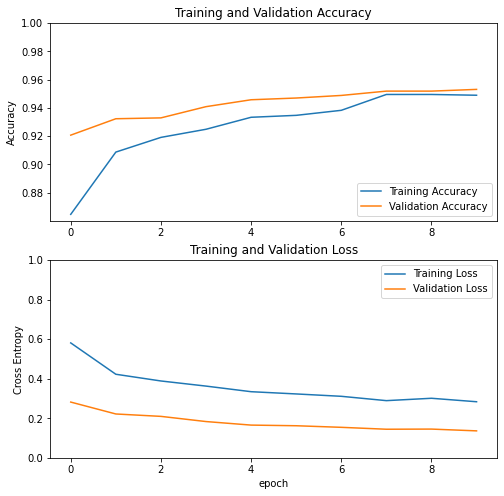

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)


plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Finetuning:**

Für das Finetuning werden einige der Schichten des Modells "entforen" und weiter trainiert.

In [ ]:
mobilenet_base.trainable = True
print("Anzahl der aller Schichten im Modell: ", len(mobilenet_base.layers))

Anzahl der aller Schichten im Modell:  154


Einfrieren aller Schichten bis zu der, ab der trainiert werden soll:

In [ ]:
fine_tune_at = 100

for layer in mobilenet_base.layers[:fine_tune_at]:
  layer.trainable =  False

Konfiguration des Modells:

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [ ]:
print("Anzahl trainiebarer Schichten: " + str(len(model.trainable_variables)))

Anzahl trainiebarer Schichten: 58


Fortsetzen des Trainings:

In [ ]:
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         class_weight = classes_weights)

Epoch 10/15
115/115 [==============================] - 13s 88ms/step - loss: 0.2692 - accuracy: 0.9574 - val_loss: 0.1346 - val_accuracy: 0.9537
Epoch 11/15
115/115 [==============================] - 10s 82ms/step - loss: 0.2593 - accuracy: 0.9579 - val_loss: 0.1249 - val_accuracy: 0.9512
Epoch 12/15
115/115 [==============================] - 10s 82ms/step - loss: 0.2501 - accuracy: 0.9588 - val_loss: 0.1214 - val_accuracy: 0.9537
Epoch 13/15
115/115 [==============================] - 10s 82ms/step - loss: 0.2444 - accuracy: 0.9629 - val_loss: 0.1220 - val_accuracy: 0.9524
Epoch 14/15
115/115 [==============================] - 10s 82ms/step - loss: 0.2453 - accuracy: 0.9634 - val_loss: 0.1245 - val_accuracy: 0.9543
Epoch 15/15
115/115 [==============================] - 10s 82ms/step - loss: 0.2311 - accuracy: 0.9645 - val_loss: 0.1268 - val_accuracy: 0.9512


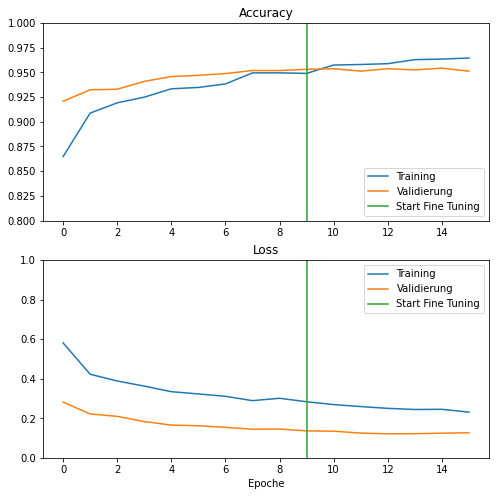

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training')
plt.plot(val_acc, label='Validierung')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training')
plt.plot(val_loss, label='Validierung')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('Epoche')
plt.show()

### 2.3 Evaluieren des Modells

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

25/25 [==============================] - 2s 53ms/step - loss: 0.1391 - accuracy: 0.9525
Test accuracy : 0.9524999856948853


In [ ]:
y_pred = []
y_true = []
X = []

for image_batch, label_batch in test_dataset:
   X.append(image_batch.numpy())
   y_true.append(label_batch)
   preds = model.predict(image_batch)
   y_pred.append(preds)

correct_labels = tf.concat([item for item in y_true], axis = 0).numpy().astype(int)
predicted_labels_logits = tf.concat([item for item in y_pred], axis = 0).numpy()

predicted_labels = []

for logit in predicted_labels_logits:
  prediction = tf.round(tf.nn.sigmoid(logit))
  predicted_labels.append(prediction)

X_conc = tf.concat([item for item in X], axis = 0).numpy()

In [ ]:
print(classification_report(correct_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       655
           1       0.89      0.84      0.87       145

    accuracy                           0.95       800
   macro avg       0.93      0.91      0.92       800
weighted avg       0.95      0.95      0.95       800



[[640  15]
 [ 23 122]]


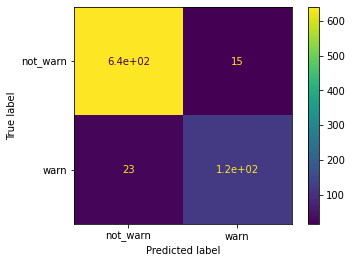

In [ ]:
conf_matr = confusion_matrix(correct_labels, predicted_labels)
print(conf_matr)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matr, display_labels=["not_warn", "warn"])
disp.plot()
plt.show()

## 3. Komprimierung

Definieren der Pfade zu den Modell-Dateien:

In [ ]:
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model_quant.tflite'

Speichern des erstellten Modells:

In [ ]:
model.save(MODEL_TF)

INFO:tensorflow:Assets written to: models/model/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Konvertieren des Modells in das .tflite-Format und Speichern der Datei (**ohne** Quantisierung):

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
model_no_quant_tflite = converter.convert()
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

1781696

Konvertieren des Modells in das .tflite-Format und Speichern der Datei (**mit** Quantisierung):

* Quantisierungsmethode: Full Integer Quantization (INT8)

In [ ]:
def representative_dataset():
  for image_batch, labels_batch in train_dataset:
    yield [image_batch]

converter_quantization = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
converter_quantization.optimizations = [tf.lite.Optimize.DEFAULT]
converter_quantization.representative_dataset = representative_dataset
converter_quantization.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter_quantization.inference_input_type = tf.int8
converter_quantization.inference_output_type = tf.int8

tflite_model_quant = converter_quantization.convert()

In [ ]:
open(MODEL_TFLITE, "wb").write(tflite_model_quant)

671448

## 4. Vergleich nicht komprimiert vs. komprimiert

In [ ]:
size_no_quant_tflite = os.path.getsize(MODEL_NO_QUANT_TFLITE)
size_tflite = os.path.getsize(MODEL_TFLITE)

pd.DataFrame.from_records(
    [["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", ""],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]], columns = ["Model", "Size", ""], index="Model")

,Size,
Model,,
TensorFlow Lite,1781696 bytes,
TensorFlow Lite Quantized,671448 bytes,(reduced by 1110248 bytes)


Funktionen zum Ausführen und evaluieren eines (komprimierten) tflite-Modells:

In [ ]:
def set_input_tensor(interpreter, input):
  input_details = interpreter.get_input_details()[0]
  tensor_index = input_details['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  scale, zero_point = input_details['quantization']
  input_tensor[:, :] = np.int8(input / scale + zero_point)

def classify_image(interpreter, input):
  set_input_tensor(interpreter, input)
  interpreter.invoke()
  output_details = interpreter.get_output_details()[0]
  output = interpreter.get_tensor(output_details['index'])
  scale, zero_point = output_details['quantization']
  output = scale * (output - zero_point)
  logit = output
  return logit

In [ ]:
interpreter = tf.lite.Interpreter('/content/models/model_quant.tflite')
interpreter.allocate_tensors()
quantized_predictions_logits = []

for image in X_conc:
  quant_pred_logit = classify_image(interpreter, image)
  quantized_predictions_logits.append(quant_pred_logit)

In [ ]:
quantized_predictions = []
for logit in quantized_predictions_logits:  
  quantized_prediction_binary = tf.round(tf.nn.sigmoid(logit)).numpy().flatten()
  quantized_predictions.append(quantized_prediction_binary)

quantized_predictions = np.asarray(quantized_predictions)

Ergebnis-Metriken quantisiert:

In [ ]:
print(classification_report(correct_labels, quantized_predictions))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       655
           1       0.97      0.61      0.75       145

    accuracy                           0.93       800
   macro avg       0.94      0.80      0.85       800
weighted avg       0.93      0.93      0.92       800



[[652   3]
 [ 56  89]]


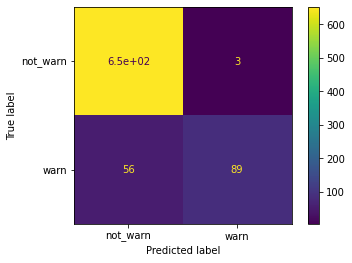

In [ ]:
conf_matr = confusion_matrix(correct_labels, quantized_predictions)
print(conf_matr)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matr, display_labels=["not_warn", "warn"])
disp.plot()
plt.show()

## Quellen

In dem Notebook wird u. a. angepasster Code aus folgenden Quellen verwendet:
* https://www.tensorflow.org/tutorials/images/transfer_learning
* https://www.tensorflow.org/lite/performance/post_training_integer_quant
* https://colab.research.google.com/github/google-coral/tutorials/blob/master/retrain_classification_ptq_tf1.ipynb#scrollTo=RkQ2IlAWfC5O
* https://colab.research.google.com/github/tensorflow/tflite-micro/blob/main/tensorflow/lite/micro/examples/hello_world/train/train_hello_world_model.ipynb#scrollTo=wEXiJ8dFkL2R